In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import sys
sys.path.append("../scripts")

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
plt.rcParams["figure.figsize"] = (14,6)

In [45]:
data = pd.read_hdf("../data/ts-covid-provinces.hdf", key="China")
data

Province   Anhui              Beijing              Chongqing     ... Xinjiang  \
               C  D    I    R       C  D    I    R         C  D  ...        I   
date                                                             ...            
2020-01-28    42  0   42    0      50  0   48    1        59  0  ...        3   
2020-01-29    64  0   64    0      64  0   61    2        79  0  ...        5   
2020-01-30    91  0   91    0      77  0   74    2       104  0  ...        7   
2020-01-31   123  0  122    1      92  0   88    3       130  0  ...        9   
2020-02-01   160  0  158    1     110  0  105    4       157  0  ...       11   
...          ... ..  ...  ...     ... ..  ...  ...       ... ..  ...      ...   
2020-06-05   991  6    0  985     593  9    2  581       579  6  ...        0   
2020-06-06   991  6    0  985     593  9    2  582       579  6  ...        0   
2020-06-07   991  6    0  985     593  9    2  582       579  6  ...        0   
2020-06-08   991  6    0  985     593  9    2  582       579  6  ...        0   
2020-06-09   991  6    0  985     594  9    1  583       579  6  ...        0   

Province       Yunnan             Zhejiang                
             R      C  D   I    R        C  D    I     R  
date                                                      
2020-01-28   0     15  0  15    0       78  0   77     1  
2020-01-29   0     22  0  22    0      119  0  117     1  
2020-01-30   0     32  0  32    0      176  0  174     2  
2020-01-31   0     43  0  43    0      247  0  243     3  
2020-02-01   0     55  0  54    0      323  0  317     6  
...         ..    ... ..  ..  ...      ... ..  ...   ...  
2020-06-05  73    185  2   0  183     1268  1    0  1267  
2020-06-06  73    185  2   0  183     1268  1    0  1267  
2020-06-07  73    185  2   0  183     1268  1    0  1267  
2020-06-08  73    185  2   0  183     1268  1    0  1267  
2020-06-09  73    185  2   0  183     1268  1    0  1267  

[134 rows x 132 columns]

In [46]:
obs = data["Hunan"]
obs = obs[["I", "R", "D"]]
obs

,I,R,D
date,,,
2020-01-28,56,0,0
2020-01-29,87,0,0
2020-01-30,125,0,0
2020-01-31,168,0,0
2020-02-01,217,1,0
...,...,...,...
2020-06-05,0,1015,4
2020-06-06,0,1015,4
2020-06-07,0,1015,4


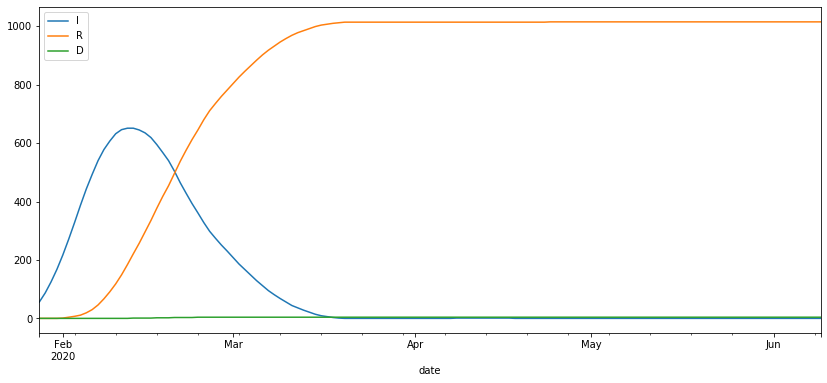

In [47]:
obs.plot()

In [48]:
def train_test_split(data, split, start=None, end=None):
    if start is None:
        start = data.index[0]
    if end is None:
        end = data.index[-1]
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    split = pd.to_datetime(split)
    one = pd.DateOffset(days=1)
    train = data[start:split-one].copy()
    test = data[split:end].copy()
    return train, test

In [49]:
#data_start = "2020-04-01"
data_split = "2020-04-01"
train, test = train_test_split(obs, split=data_split)

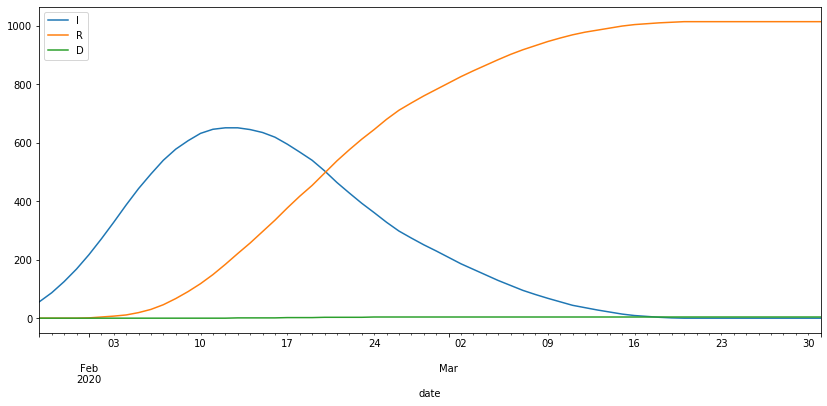

In [50]:
train.plot()

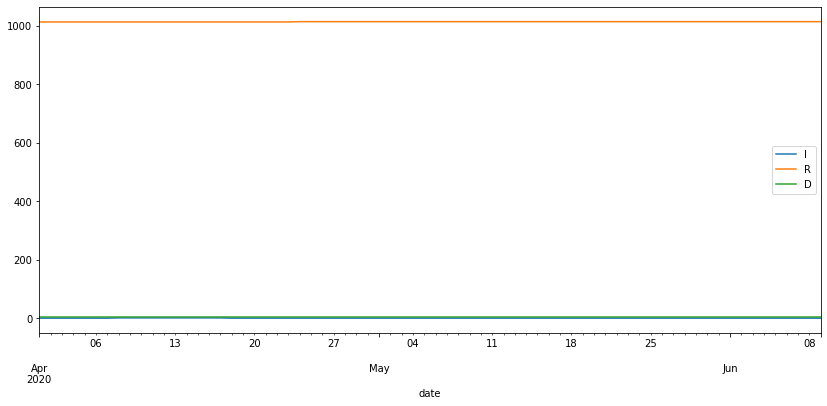

In [51]:
test.plot()

## SIR

In [52]:
from SEIR import SIR

In [53]:
init_I, init_R, init_D = train.iloc[0, :]

In [54]:
model = SIR(
    population=1e3, 
    init_infected=init_I, 
    init_recovered=init_R, 
    init_dead=init_D,
    r_transmission=0.5,
    r_recovery=1/17,
    r_mortality=0
)

In [55]:
model.fit(train, estimate=('r_transmission', "r_recovery", "r_mortality", "population"), 
          method="Nelder-Mead", options={"maxiter": 5000})

 final_simplex: (array([[3.76972895e-01, 6.17576515e-02, 7.51790353e-04, 1.08898148e+03],
       [3.76972890e-01, 6.17576512e-02, 7.51785929e-04, 1.08898143e+03],
       [3.76972824e-01, 6.17576626e-02, 7.51789308e-04, 1.08898155e+03],
       [3.76972911e-01, 6.17576413e-02, 7.51788505e-04, 1.08898149e+03],
       [3.76972961e-01, 6.17576541e-02, 7.51786405e-04, 1.08898142e+03]]), array([542321.37704424, 542321.37704427, 542321.37704439, 542321.37704442,
       542321.37704446]))
           fun: 542321.3770442377
       message: 'Optimization terminated successfully.'
          nfev: 245
           nit: 140
        status: 0
       success: True
             x: array([3.76972895e-01, 6.17576515e-02, 7.51790353e-04, 1.08898148e+03])

In [56]:
T = len(train) + len(test)
res = model.simulate(until=T)
idx = pd.date_range(start=train.index[0], periods=T, freq="D")
res.index = idx

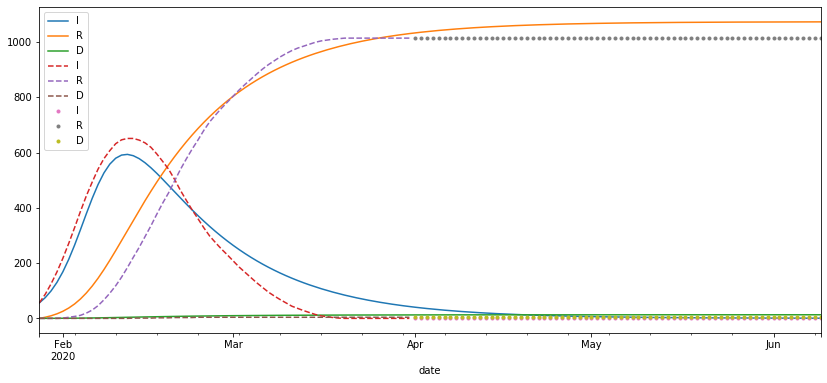

In [57]:
ax = res.plot()
train.plot(ax=ax, style="--")
test.plot(ax=ax, style=".")